In [1]:
from google.colab import drive
drive.mount('/content/gdrive') #130

Mounted at /content/gdrive


In [2]:
!git clone https://github.com/eitanrich/lin-im2im.git

Cloning into 'lin-im2im'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 38 (delta 11), reused 15 (delta 1), pack-reused 0
Unpacking objects: 100% (38/38), done.


In [3]:
%%capture 

!mkdir /root/.kaggle
!cp '/content/gdrive/My Drive/kaggle.json' /root/.kaggle/
!kaggle datasets download -d jessicali9530/celeba-dataset

!rm -rf /content/lin-im2im/datasets/CelebA/
!mkdir -p  /content/lin-im2im/datasets/CelebA/celeba
!unzip celeba-dataset.zip -d /content/lin-im2im/datasets/CelebA/celeba

In [4]:
!ls '/content/gdrive/My Drive/CelebA/Anno/'

identity_CelebA.txt   list_bbox_celeba.txt     list_landmarks_align_celeba.txt
list_attr_celeba.txt  list_eval_partition.txt  list_landmarks_celeba.txt


In [5]:
import glob, shutil
for file_ in glob.glob('/content/gdrive/My Drive/CelebA/Anno/*.txt'):
    save_name= file_.split('/')[-1]
    shutil.copyfile(file_, f'/content/lin-im2im/datasets/CelebA/celeba/{save_name}')


In [6]:
!mv /content/lin-im2im/datasets/CelebA/celeba/img_align_celeba/img_align_celeba  /content/lin-im2im/datasets/CelebA/celeba/img_align_celeba_new/
!rm -rf /content/lin-im2im/datasets/CelebA/celeba/img_align_celeba/
!mv /content/lin-im2im/datasets/CelebA/celeba/img_align_celeba_new/ /content/lin-im2im/datasets/CelebA/celeba/img_align_celeba/

In [33]:
%cd /content/lin-im2im

/content/lin-im2im


In [ ]:
!apt install libomp-dev
!python -m pip install --upgrade faiss faiss-gpu

```
usage: run_im2im.py [--dataset {celeba,ffhq,shoes}]
                    [--resolution RESOLUTION]
                    [--a_transform {identity,rot90,vflip,edges,Canny-edges,colorize,super-res,inpaint}]
                    [--pairing {paired,matching,nonmatching,few-matches}]
                    [--matching {nn,cyc-nn}]
                    [--transform_type {orthogonal,linear}] [--n_iters N_ITERS]
                    [--n_components N_COMPONENTS] [--n_train N_TRAIN]
                    [--n_test N_TEST]

```

# Dataset

In [9]:
!cp -r '/content/gdrive/MyDrive/In-Bed-Human-Pose-Estimation(VIP-CUP)' /content

In [66]:
%%writefile run_im2im.py

import os
import torch
import argparse
import numpy as np
import matplotlib
from data import get_data
from pca_linear_map import PCALinMapping
from matplotlib import pyplot as plt
import time
from imageio import imwrite
from utils import mosaic
import yaml
import pickle as pkl


def save_results(a_to_b, X_A_test, X_B_test, args, save_model=False):
    outfolder = os.path.join('results', 'run-{}'.format(time.strftime('%b-%d-%H:%M:%S', time.localtime(time.time()))))
    os.makedirs(outfolder, exist_ok=True)

    with open(os.path.join(outfolder, 'args.yaml'), 'w') as f:
        print(yaml.dump(vars(args), default_flow_style=False), file=f)

    print('Applying the learned transformation on test data...')
    X_A_test_to_A = a_to_b.reconstruct_a(X_A_test)
    X_A_test_to_B = a_to_b.transform_a_to_b(X_A_test)
    #n_cols = 1 if X_A_test.shape[0] < 5 else None
    n_cols=None
    imwrite(os.path.join(outfolder, 'input_a.jpg'), mosaic(X_A_test, n_cols=n_cols))
    imwrite(os.path.join(outfolder, 'reconstructed_a.jpg'), mosaic(X_A_test_to_A, n_cols=n_cols))
    if X_B_test is not None:
        imwrite(os.path.join(outfolder, 'target_b.jpg'), mosaic(X_B_test, n_cols=n_cols))
        X_B_test_to_B = a_to_b.reconstruct_b(X_B_test)
        imwrite(os.path.join(outfolder, 'reconstructed_b.jpg'), mosaic(X_B_test_to_B, n_cols=n_cols))
    imwrite(os.path.join(outfolder, 'a_to_b.jpg'), mosaic(X_A_test_to_B, n_cols=n_cols))
    plt.matshow(1.0-a_to_b.Q[:50, :50], cmap='bwr', fignum=1)
    plt.savefig(os.path.join(outfolder, 'Q.png'))
    # plt.matshow(a_to_b.pca_a.components_.T @ a_to_b.Q @ a_to_b.pca_b.components_)
    # plt.savefig(os.path.join(outfolder, 'T.png'))

    if save_model:
        pkl.dump(a_to_b, open(os.path.join(outfolder, 'model.pkl'), 'wb'))


def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('--dataset', choices=['celeba', 'ffhq', 'shoes'], default='celeba')
    parser.add_argument('--resolution', help='resized image height(=width) after cropping', type=int, default=64)
    parser.add_argument('--a_transform', choices=['identity', 'rot90', 'vflip', 'edges', 'Canny-edges', 'colorize', 'super-res', 'inpaint'], default='identity')
    parser.add_argument('--pairing', choices=['paired', 'matching', 'nonmatching', 'few-matches'], default='matching')
    parser.add_argument('--matching', choices=['nn', 'cyc-nn'], default='cyc-nn')
    parser.add_argument('--transform_type', choices=['orthogonal', 'linear'], default='orthogonal')
    parser.add_argument('--n_iters', type=int, default=50)
    parser.add_argument('--n_components', type=int, default=1000)
    parser.add_argument('--n_train', type=int, default=None)
    parser.add_argument('--n_test', type=int, default=100)
    args = parser.parse_args()

    torch.manual_seed(1)
    np.random.seed(1)
    print('Loading {} data for {} - {} ...'.format(args.pairing, args.dataset, args.a_transform))
    X_A, X_B, X_A_test, X_B_test = get_data(args)

    print('Learning {} transformation in {} PCA dimensions...'.format(args.transform_type, args.n_components))

    a_to_b = PCALinMapping(args).fit(X_A, X_B)
    save_results(a_to_b, X_A_test, X_B_test, args)

if __name__ == "__main__":
    torch.multiprocessing.set_sharing_strategy('file_system')
    main()

Overwriting run_im2im.py


In [81]:
%%writefile /content/lin-im2im/utils.py

import torch
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import cv2


class ReshapeTransform:
    def __init__(self, new_size):
        self.new_size = new_size

    def __call__(self, img):
        return torch.reshape(img, self.new_size)


class CropTransform:
    def __init__(self, bbox):
        self.bbox = bbox

    def __call__(self, img):
        return img.crop(self.bbox)


def mosaic(X, name=None, show=False, clip=True, to_uint8=True, ch_first=False, n_cols=None, is_gray=True):
    is_flat = len(X.shape) == 2
    if is_gray==True:
        X_color=[]
        if is_flat:img_size = int(np.sqrt(X.shape[1]))
        else:raise Exception('Not implemented')

        for x_ in X:
            X_color.append(cv2.cvtColor(x_.reshape(img_size, img_size),cv2.COLOR_GRAY2RGB).flatten())
        X= np.array(X_color)
    

    w = int(np.sqrt(X.shape[1]/3)) if is_flat else X.shape[2]
    print(X.shape, w)
    if ch_first:
        if is_flat:
            X = X.reshape(-1, 3, w, w)
        X = np.transpose(X, [0, 2, 3, 1])
    elif is_flat:
        X = X.reshape(-1, w, w, 3)

    if clip:
        X = np.clip(X, 0.0, 1.0)
    n_cols = n_cols or int(np.sqrt(X.shape[0]))
    n_rows = X.shape[0] // n_cols

    mosaic_image = np.vstack([np.hstack([X[i*n_cols+j] for j in range(n_cols)]) for i in range(n_rows)])
    if show:
        plt.figure()
        plt.imshow(mosaic_image)
        plt.axis('off')
        if name:
            plt.title(name)
    if to_uint8:
        mosaic_image = (mosaic_image * 255.0).astype(np.uint8)
    return mosaic_image

Overwriting /content/lin-im2im/utils.py


In [82]:
#Function to visualize data set

%load_ext autoreload
%autoreload 2

import os
import sys
import shutil 
import glob

import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2 as cv


import torch
import torchvision
from time import time
from torchvision import datasets, transforms
from torchvision.io import read_image
from torch import nn, optim
from torch.utils.data import Dataset


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
uncover_img_dirs = sorted(glob.glob('/content/In-Bed-Human-Pose-Estimation(VIP-CUP)/train/*/IR/uncover/*'))
cover1_img_dirs = sorted(glob.glob('/content/In-Bed-Human-Pose-Estimation(VIP-CUP)/train/*/IR/cover1/*'))
cover2_img_dirs = sorted(glob.glob('/content/In-Bed-Human-Pose-Estimation(VIP-CUP)/train/*/IR/cover2/*'))
length = min(len(uncover_img_dirs), len(cover1_img_dirs))

is_gray=True

In [31]:
uncover_rgb_dirs = sorted(glob.glob('/content/In-Bed-Human-Pose-Estimation(VIP-CUP)/train/*/RGB/uncover/*'))

uncover_ir_dirs=[]
for rgb_img in uncover_rgb_dirs:
  dir_parts= rgb_img.split('/')
  dir_parts[-3]='IR'
  uncover_ir_dirs.append('/'.join(dir_parts))
length = len(uncover_ir_dirs)

is_gray=False

In [84]:
from sklearn.model_selection import train_test_split

domain1_train, domain1_test, domain2_train, domain2_test = train_test_split(cover1_img_dirs[:length], uncover_img_dirs[:length], test_size=0.1, random_state=42)

#domain1_train, domain1_test, domain2_train, domain2_test = train_test_split(uncover_ir_dirs[:length], uncover_rgb_dirs[:length], test_size=0.1, random_state=42)

print(f'train length : {len(domain1_train)}, test length : {len(domain1_test)}')

train length : 1012, test length : 113


In [85]:
import cv2
def get_images(dirs, n_samples, resize_size= 64, gray=True):
    images = []
    n_samp=-1
    while True:
        for i in range(len(dirs)):
            n_samp+=1
            if n_samp>=n_samples:break
            dir_ = dirs[i]
            if gray==True:
              img = cv2.cvtColor(cv2.imread(dir_), cv2.COLOR_BGR2GRAY)
            else:
              img = cv2.cvtColor(cv2.imread(dir_), cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (resize_size, resize_size))
            images.append(img.flatten())
        if n_samp>=n_samples:break
    return np.array(images).astype('float32')/255.0

# Model

In [86]:
%cd /content/lin-im2im
class interactive_parser():
    def __init__(self, args):
        for arg_name in args.keys():
            setattr(self, arg_name, args[arg_name])

/content/lin-im2im


In [87]:
args_dict= {
    'dataset':'celeba',
    'resolution':64,
    'a_transform':'identity',
    'pairing':'paired',
    'matching':'cyc-nn',
    'transform_type':'orthogonal',
    'n_iters':50,
    'n_components':2000,
    'n_train':2000,
    'n_test':10}
args = interactive_parser(args_dict)


import torch
import numpy as np
from data import get_data
from pca_linear_map import PCALinMapping
from run_im2im import save_results 

torch.manual_seed(1)
np.random.seed(1)

In [88]:
X_A = get_images(domain1_train, args.n_train, args.resolution, gray=is_gray)
X_B = get_images(domain2_train, args.n_train, args.resolution, gray=is_gray)
X_A_test = get_images(domain1_test, args.n_test, args.resolution, gray=is_gray)
X_B_test = get_images(domain2_test, args.n_test, args.resolution, gray=is_gray)

In [89]:
X_A.shape[1]**0.5

64.0

Got 2000 samples in A and 2000 in B.
PCA A...
PCA B...
Synchronizing...
Using skew-based logic for 1897/2000 dimensions.
PCA representations:  (2000, 2000) (2000, 2000) took: 5.149190187454224
Learning orthogonal transformation using paired sets:
took 4.73 sec.
Applying the learned transformation on test data...
(10, 12288) 64
(10, 12288) 64
(10, 12288) 64
(10, 12288) 64
(10, 12288) 64


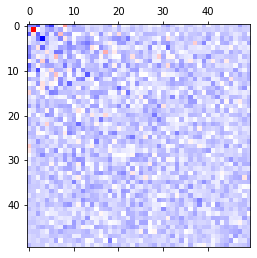

In [90]:
a_to_b = PCALinMapping(args).fit(X_A, X_B)
save_results(a_to_b, X_A_test, X_B_test, args)